In [1]:
# Import Modules
import pandas as pd
import numpy as np
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Figure
from ipywidgets import interact
from IPython.display import display
import ipywidgets
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sb
import warnings


In [2]:
# Set the notebook to display all columns of a dataframe
pd.set_option("display.max_columns", None)

# Suppress warnings for clean cell outputs
warnings.filterwarnings("ignore")


# Load Data

In [3]:
# Load in cleaned & combined data
# - processed in long format
out_df = pd.read_csv("./data/complete_dataset_LongFormat.csv")


## **Examine Relationships in a Scatter Plot Matrix (SPLOM)**
Let's take a look at the structure of our data using a scatterplot matrix. This will give us some high-level insight into the structure of the data before we run correlation analysis.

In [4]:
# Grab a dataframe of only the variables of interest
splom_df = out_df[
    [col for col in out_df.columns if col not in ["Country", "c_code", "Year"]]
]

# Examine a scatterplot matrix of all columns in our data
fig = px.scatter_matrix(splom_df, width=1000, height=1000)
fig.show()


### Observations from the SPLOM
* It's interesting that our variables of interest (percent poverty, Total GHG, Total GDP) are 'squashed' onto the vertical or horizontal axes. When visualizing these trends with a regression line, it may be useful to perform a log transformation so we can see the trends more clearly. 
* There appear to be 'clusters' of trend lines in several variables. Could these be specific to trends in one particular country? This may be interesting to investigate further.
    * GHG vs Total GDP 
    * Total Population and Total GHG 
    * Total Population and Total GHG

## **Investigate Scatterplot Trends Further**
Here I'm going to further investigate the trends identified in the previous cell using one scatterplot. Using ipywidgets interact, I'd like to add functionality to select various variables to analyze. I'm going to add a feature to this scatterplot that has a tooltip so we see if the 'clusters' of trends are related to one specific country. I'm also going to add the option to log-scale the plot's axes so the relationships that exist on a smaller scale aren't hidden from us. 

In [5]:
def get_scatterplot(var_x="GDP_Total", var_y="Total_GHG", log=False, country=""):
    """
    Function that generates a scatterplot of var_y as
    a function of var_x. Option to set the vertical axis
    to a log scale using the log argument.

    Parameters:

        var_x: variable to plot on the x axis.

        var_y: variable to plot on the y axis.

        log: if True, scales the vertical axis logarithmically.
             Normal scale if set to False

        country: str, option to show data for a specific country.

    Returns:

        A scatterplot of var_x and var_y.
    """

    # filter the data for a specific country
    # if a country name is passed to the function
    if country:
        select = out_df[out_df["Country"] == country]
    else:
        select = out_df.copy()

    fig = px.scatter(
        select, x=var_x, y=var_y, hover_data=["Country", "Year"], log_y=log, log_x=log
    )

    return fig


# Variables to use in the ipy widget
var_list = [var for var in splom_df.columns]

ipywidgets.interact(get_scatterplot, var_x=var_list, var_y=var_list)


interactive(children=(Dropdown(description='var_x', options=('GDP_Total', 'Percent_Poverty', 'Total_GHG', 'Tot…

<function __main__.get_scatterplot(var_x='GDP_Total', var_y='Total_GHG', log=False, country='')>

### Observations from Interactive Singluar Scatterplot
* Not surprisingly, my intuition that these clusters of trends were specific to a particular country was correct. 
    * <u>**Total GDP (x) and Total GHG (y):**</u> We can see US and China stick out like a sore thumb. If we take the log of this relationship it appears to be strongly correlated and linear. It's also interesting that the values increase and decrease in this graph sequentially with time. 
        * Several outlier countries are observed below the increasing trend:
            * Latvia 
            * Finland
            * Switzerland
            * Sweeden
            * Norway
            * Bhutan
            * Liechtenstein 
            * Montenegro
            * Iceland 
            * Andorra 
    * <u>**Total Population (x) and Total GHG (y)**:</u> Here we can actually observe the development of India and China in this plot! As population increases, we see GHG emissions increase exponentially for China, whereas GHG emissions increase more steadily for India. 
        * I wonder what caused the brief pause in GHG emissions between 2013 and 2016 in China?
        * Between 1990 and 2000, Belize was able to decrease their emissions as their population increased!
    * <u>**Total GDP (x) and Percent Poverty:**</u> This relationship is best visualized with both axes in log scale. A weak negative correlation is observed here. One interesting trend that can be seen in this plot is the exponential decrease of China's poverty percentage as its Total GDP increases. Ukraine appears to be an outlier with high GDP and low percent poverty.
    * <u>**Total GHG (x) and Percent Poverty:**</u> Since GHG is so highly correlated with GDP, it's not surprising that this relationship is so similar to GDP vs. Percent Poverty, although this relationship appears to be much weaker. 
* Given that these variables show a mostly linear relationship, we'll use pearson's correlation coefficients to quanitify the correlations.

### **Look at a Pearson's Correlation Matrix for Variables**
To get a quick idea of the relationships identified in the previous scatterplots, let's use Seaborn's heatmap visual and the pandas dataframe `.corr` method to visualize the pearson correlation coefficients between variables. 

<AxesSubplot: >

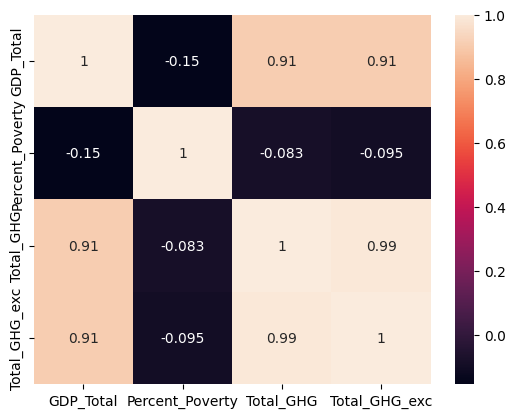

In [6]:
# Let's look at Pearson's correlation coefficients in our data
# using a seaborn correlation heatmap
corr = splom_df.corr(method="pearson")
sb.heatmap(corr, annot=True)


### Observations of Correlations
* **GDP Total and GHG Total** have a decent positive correlation (0.91).
* **GDP Total and Percent Poverty** show a weak negative correlation (-0.15).
* **GHG total and Percent Poverty** show a weak negative correlation (-0.083).

## **Correlations Over Time**

Here I'm going to investigate how certain correlations between our variables change over time. I want to know if the relationships vary widely from year to year, or if they don't change much at all. I'm going to implement this using a groupby. I'll groupby year and apply `scipy.stats.pearsonr`. Along with returning the correlation coefficient and p-value, I'm also going to include an `n` variable to assess the statistical power associated with the test.

### Get the correlations in a single dataframe for each variable within each year

In [7]:
def get_corr_over_time(dat):
    """
    Function to be used in a pandas groupby to
    return the correlation of each variable that exists in
    the dataframe dat as a column.

    Parameters:

        dat: a dataframe with columns that represent variables
             that will be analyzed

    Returns:

        dataframe: a dataframe that gives the variables analyzed,
                   the correlation coefficient, the p-value, and the
                   number of samples in the output.
    """

    # Get the variables to analyze
    analyze_vars = [
        col for col in dat.columns if col not in ["Year", "c_code", "Country"]
    ]

    analyzed = []

    # Dictionary to accumulate data
    corr_labels = [
        "Var_1",
        "Var_2",
        "Var_Label",
        "Pearson",
        "Pearson_Pval",
        "Spearman",
        "Spearman_Pval",
        "n",
    ]

    # Output dataframe
    out_dat = pd.DataFrame()

    # Loop through each variable
    for var in analyze_vars:
        analyzed.append(var)
        for var2 in analyze_vars:
            if var2 not in analyzed:

                # Get all records that don't have null values
                not_null_df = dat[(dat[var].notnull()) & (dat[var2].notnull())]

                # Skip the analysis if there are less
                # than 2 values
                if len(not_null_df) <= 2:
                    continue

                # Run the pearson correlation
                (
                    pear_coef,
                    pear_pval,
                ) = pearsonr(not_null_df[var], not_null_df[var2])

                # Run a spearman correlation
                spear_coef, spear_pval = spearmanr(not_null_df[var], not_null_df[var2])

                # Get the number of values in the test
                n = len(not_null_df)

                # Label for the correlation
                var_label = var + " + " + var2

                # List of variables
                output = [
                    var,
                    var2,
                    var_label,
                    pear_coef,
                    pear_pval,
                    spear_coef,
                    spear_pval,
                    n,
                ]

                # Add data to dictionary
                out_dict = {val: [output[i]] for i, val in enumerate(corr_labels)}

                # Add correlations to output dataframe
                current_df = pd.DataFrame(out_dict)
                out_dat = pd.concat([out_dat, current_df], axis=0)

    return out_dat


# Run the groupby and generate the correlation df
corr_df = out_df.groupby("Year").apply(get_corr_over_time).reset_index()
corr_df.drop("level_1", axis=1, inplace=True)


### Visualize the correlations overtime
Let's use altair to show a time series of the pearson correlations for each variable. We will also use ipywidgets interact to allow us to quickly select which variables we want to analyze.

In [8]:
def get_corr_time_series(var="GDP_Total"):
    select_df = corr_df[corr_df["Var_Label"].str.contains(var)]
    out_chart = (
        alt.Chart(select_df)
        .mark_line(point=alt.OverlayMarkDef(filled=True))
        .encode(
            x=alt.X("Year:N"),
            y=alt.Y("Pearson:Q"),
            color=alt.Color("Var_Label:N"),
            tooltip=[
                "Var_1:N",
                "Var_2:N",
                "Year:N",
                "Pearson:Q",
                "Pearson_Pval:Q",
                "n:Q",
            ],
        )
        .properties(height=500, width=800)
    )

    return out_chart


# Use ipywidgets to specify a drop-down list of variables in the dataframe to explore
ipywidgets.interact(
    get_corr_time_series, var=[val for val in corr_df["Var_1"].unique()]
)


interactive(children=(Dropdown(description='var', options=('GDP_Total', 'Percent_Poverty', 'Total_GHG'), value…

<function __main__.get_corr_time_series(var='GDP_Total')>

### Observations of Correlations overtime 
* **GHG Emissions** - Correlations with GHG do not fluctuate greatly over time for all variables except for percent poverty. Percent poverty has a weak to medium negative correlation with GHG emissions most of the time, especially when the sample size increases. 
* **GDP Total** - Not much change in the correlations over time for GDP and other variables. Most of the changes in correlation coefficients is observed with the Poverty data - for which we have very low statistical power. 
* **Percent Poverty** as mentioned above, the correlations with this variable changes quite a bit overtime. Fluctuations are observed the most in the 90's and early 2000s, mostly due to the reason that there are not many samples and low statistical power. As more data become available in the 2010s, the correlations appear to stabilize. It appears that percent poverty is more negatively correlated with GDP than with GHG.

## **Correlations for specific Countries**
Seeing this visual makes me wonder what the correlations may look like for specific countries over time. What if we repeat this analysis and look at the relationships of these variables within specific countries? While the relationship may not always be linear, the pearson's r would still be helpful in seeing strengths of relationships.

In [9]:
# Run the groupby and generate the correlation df
country_corr_df = out_df.groupby("Country").apply(get_corr_over_time).reset_index()
country_corr_df.drop("level_1", axis=1, inplace=True)


In [10]:
# Examine relationships in Excel
# country_corr_df.to_csv("./data/corr_country.csv", index=False)

country_corr_df.head()


,Country,Var_1,Var_2,Var_Label,Pearson,Pearson_Pval,Spearman,Spearman_Pval,n
0,Afghanistan,GDP_Total,Total_GHG,GDP_Total + Total_GHG,0.928537,4.657694e-10,0.889850,2.990585e-08,22
1,Afghanistan,GDP_Total,Total_GHG_exc,GDP_Total + Total_GHG_exc,0.929041,4.348820e-10,0.869406,1.502639e-07,22
2,Afghanistan,Total_GHG,Total_GHG_exc,Total_GHG + Total_GHG_exc,0.992834,2.205288e-27,0.992434,4.707381e-27,30
3,Albania,GDP_Total,Percent_Poverty,GDP_Total + Percent_Poverty,-0.589856,9.546308e-04,-0.547538,2.563243e-03,28
4,Albania,GDP_Total,Total_GHG,GDP_Total + Total_GHG,0.370148,4.407336e-02,0.518576,3.325939e-03,30


### Observations

There are some surprising correlations that came out of this analysis. Some results are discussed below:

- Some countries show a negative correlation between GDP and Greenhouse Gas emissions. This is interesting because it may mean that these nations are able to grow their economies without increasing their greenhouse gas emissions. Some nations include:
  - United Kingdom (-0.96, n=30)
  - France (-0.96, n=28)
  - Germany (-0.96, n=30)
  - Belgium (-0.95, n=30)
  - Sweden: (-0.95, n=30)
  - Denmark (-0.91, n=30)
- For some countries, there are strong negative relationships between GHG emissions and Percent Poverty. Perhaps industrialization has a strong effect in helping reduce poverty for several nations? This includes:
  - Philippines (-0.99, n=24)
  - Seychelles (-0.98, n=11)
  - Guyana (-0.98, n=13)
  - India (-0.98, n=24)
  - Mali (-0.97, n=30)
- A strong positive correlation was observed between GDP total and Percent Poverty in these countries. This was somewhat unexpected, but generally we see GDP generally increasing over long enough spans of time 10-30 years. We believe these variables to be confounded with the passing of time and what we are really seeing here is just a list of countries with an increasing poverty rate.
  - Comoros (0.95, n=18)
  - Yemen (0.92, n=24)
  - United States (0.90, n=30)
  - Madagascar (0.89, n=27)
  - Iraq (0.85, n=15)

### **Let's visualize some of these relationships**

Here I will make two scatterplots. One plot will show the top 5 countries that have the most negative correlation between emissions and GDP. The second plot will show the top 5 countries that have the most negative correlation with GHG emissions and percent poverty.


In [11]:
# Get countries to show for the GDP and GHG Viz
emissions_countries = {
    c["Country"]: f"({c['Country']} {round(c['Pearson'], 2)}, n={c['n']})"
    for _, c in country_corr_df[
        country_corr_df["Var_Label"].eq("GDP_Total + Total_GHG")
    ]
    .sort_values("Pearson")
    .head()
    .iterrows()
}

corr_df_1 = out_df[out_df["Country"].isin(emissions_countries.keys())]

corr_chart_1 = (
    alt.Chart(corr_df_1)
    .mark_line(point=alt.OverlayMarkDef(filled=True))
    .encode(
        x=alt.X("GDP_Total:Q", axis=alt.Axis(title="Total GDP (current US $)")),
        y=alt.Y(
            "Total_GHG:Q",
            axis=alt.Axis(
                title="Total Greenhouse Gas Emissions (including LUCF, MtCO2)"
            ),
        ),
        color=alt.Color("Country:N"),
        tooltip=["Country", "Total_GHG:Q", "GDP_Total:Q"],
    )
)

corr_chart_1


alt.Chart(...)

## **Try a different visualization approach using facet chart**

In [12]:
corr_df_facet_plot = corr_df_1.copy()

# edit the field specifying GDP to show $ amount in billions
corr_df_facet_plot["GDP_Total"] = corr_df_facet_plot["GDP_Total"] / 1000000000

corr_df_facet_plot["Country"] = corr_df_facet_plot["Country"].apply(lambda x: emissions_countries[x])

corr_chart_1 = (
    alt.Chart(corr_df_facet_plot)
    .mark_line(point=alt.OverlayMarkDef(filled=True))
    .encode(
        x=alt.X(
            "GDP_Total:Q",
            axis=alt.Axis(title="Total GDP PPP (billions $)"),
        ),
        y=alt.Y(
            "Total_GHG:Q",
            axis=alt.Axis(
                title=["Total Greenhouse", "Gas Emissions", "(including LUCF, MtCO2)"]
            ),
        ),
        color=alt.Color("Country:N", legend=None),
    )
    .properties(height=150, width=200)
    .facet(
        facet=alt.Facet(
            "Country:N",
            header=alt.Header(
                labelFontSize=14,
                labelFontWeight="bold",
                title="Top 5 Countries with the most negative correlation between GDP and Emissions",
                titleFontSize=18,
                titleAnchor="start",
            ),
            sort=list(emissions_countries.values()),
        )
    )
    .resolve_scale(x="independent", y="independent")
)

corr_chart_1


alt.FacetChart(...)

In [13]:
%reload_ext watermark

%watermark -iv -v -m

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.1.6 (clang-1316.0.21.2.5)
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

scipy     : 1.9.1
plotly    : 5.10.0
ipywidgets: 8.0.2
altair    : 4.2.0
sys       : 3.10.6 (main, Aug 30 2022, 05:12:36) [Clang 13.1.6 (clang-1316.0.21.2.5)]
numpy     : 1.23.3
pandas    : 1.5.0
seaborn   : 0.12.0

